In [ ]:
!pip install tensorflow_text

In [3]:
import tensorflow_text

In [4]:
import pandas as pd
import numpy as np

#importer le dataframe de train prétraité par preprocessing.py
df = pd.read_pickle("../data/df_preproc.pk")
df.Entreprise = df.Entreprise.astype('category')
df.Language = df.Language.astype('category')

#Codage et décodage des entreprises/langues
company_map = { i: e for (i, e) in enumerate(df.Entreprise.cat.categories)}
lang_map = { i: e for (i, e) in enumerate(df.Language.cat.categories)}

inv_company_map = { e: i for (i, e) in enumerate(df.Entreprise.cat.categories)}
inv_lang_map = { e: i for (i, e) in enumerate(df.Language.cat.categories)}

#codage/décodage des avis
catmap = {"pos" : 0, "neg" : 1, "neu" : 2, "irr" : 3}
invmap = {0 : "pos", 1 : "neg", 2 : "neu", 3 : "irr"}

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_layer = hub.KerasLayer(module_url, trainable=True, name="BERT_encoder", output_key="pooled_output")

In [6]:
from sklearn.model_selection import train_test_split
X = ["Tweet", "Language", "Entreprise"]
y = "Avis"


lang_nb = len(df.Language.unique())

#partition en données de train/test
df_train_test = df[X + [y]].copy()
df_train_test.Avis = df_train_test.Avis.map(catmap.get)
df_train_test.Language = df_train_test.Language.map(inv_lang_map.get)
df_train_test.Entreprise = df_train_test.Entreprise.map(inv_company_map.get)

train, test = train_test_split(df_train_test, test_size=0.1, random_state=42)

In [7]:
#construction du modèle
def build_model(bert_layer, lang_nb, lr=1e-5):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
        name="preprocessing",
    )
    encoder_inputs = preprocessing_layer(text_input)

    bert_output = bert_layer(encoder_inputs)

    lang_input = tf.keras.Input(shape=(lang_nb,), name="lang")
    company_input = tf.keras.Input(shape=(4,), name="company")

    lang_layer = tf.keras.layers.Dense(8, activation="relu", name="lang_dense")(lang_input)
    company_layer = tf.keras.layers.Dense(2, activation="relu", name="comp_dense")(company_input)

    nn_input = tf.keras.layers.concatenate(
        [bert_output, lang_layer, company_layer],
        name='concatenate'
    )
    
    net = tf.keras.layers.Dense(
        128,
        activation='relu',
        name='hidden_1',
        kernel_regularizer=tf.keras.regularizers.L1(0.1),
        activity_regularizer=tf.keras.regularizers.L2(0.01)
    )(nn_input)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(
        64,
        activation='relu',
        name='hidden_2',
        kernel_regularizer=tf.keras.regularizers.L1(0.1),
        activity_regularizer=tf.keras.regularizers.L2(0.01)
    )(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(4, activation='softmax', name='output')(net)
    
    model = tf.keras.models.Model(inputs=[text_input, lang_input, company_input], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

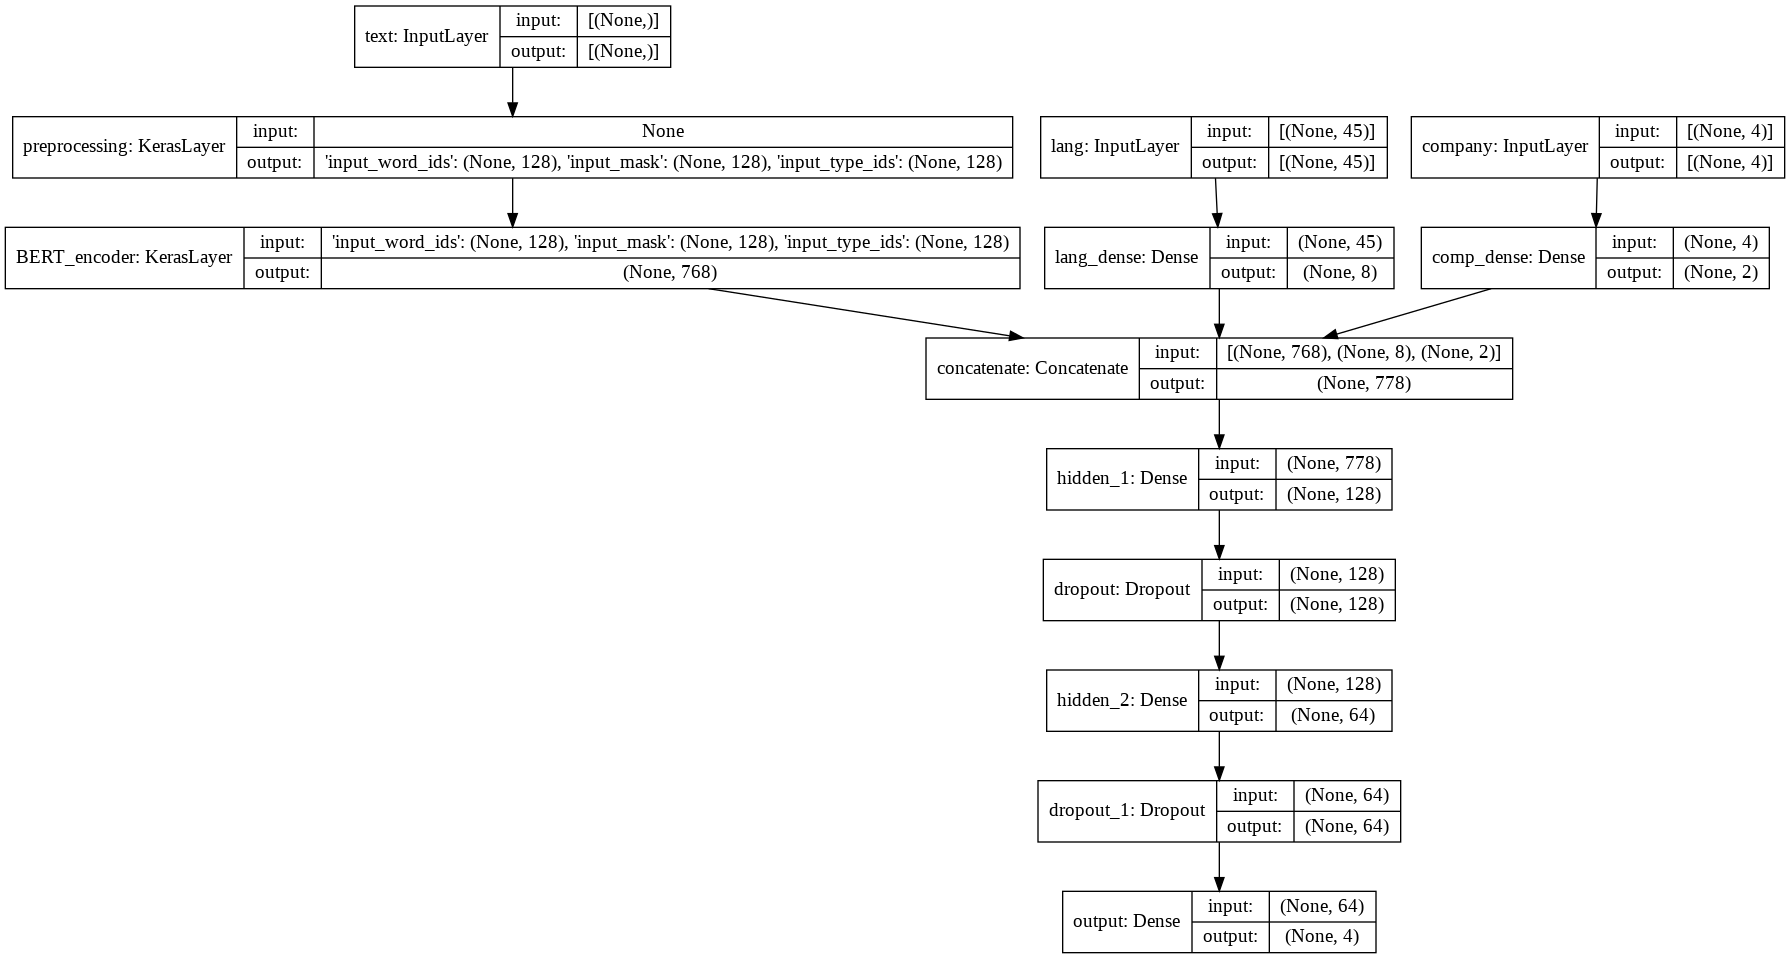

In [8]:
#entrainement du modèle
model = build_model(bert_layer, lang_nb=lang_nb, lr=0.00001)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
tf.keras.utils.plot_model(model, "plot_model.png", show_shapes=True)

In [9]:
def adapt_data_input(df):
    return (
        df.Tweet.values,
        tf.keras.utils.to_categorical(df.Language.values, lang_nb),
        tf.keras.utils.to_categorical(df.Entreprise.values, 4)
    )

In [10]:
train_history = model.fit(
    adapt_data_input(train[X]), 
    tf.keras.utils.to_categorical(train[y].values, num_classes=4),
    validation_split=.1,
    epochs=30,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/30
106/106 [==============================] - 110s 895ms/step - loss: 475.6519 - accuracy: 0.4052 - val_loss: 466.6228 - val_accuracy: 0.7580

Epoch 00001: val_accuracy improved from -inf to 0.75798, saving model to model.h5
Epoch 2/30
106/106 [==============================] - 96s 904ms/step - loss: 463.8401 - accuracy: 0.7351 - val_loss: 455.3118 - val_accuracy: 0.7819

Epoch 00002: val_accuracy improved from 0.75798 to 0.78191, saving model to model.h5
Epoch 3/30
106/106 [==============================] - 96s 904ms/step - loss: 452.5721 - accuracy: 0.7572 - val_loss: 444.1795 - val_accuracy: 0.8112

Epoch 00003: val_accuracy improved from 0.78191 to 0.81117, saving model to model.h5
Epoch 4/30
106/106 [==============================] - 96s 905ms/step - loss: 441.4443 - accuracy: 0.8230 - val_loss: 433.2356 - val_accuracy: 0.8191

Epoch 00004: val_accuracy improved from 0.81117 to 0.81915, saving model to model.h5
Epoch 5/30
106/106 [==============================] - 96s 905m

In [11]:
#évaluation
from sklearn.metrics import accuracy_score

test_input = adapt_data_input(test)
test_output = tf.keras.utils.to_categorical(test[y].values, num_classes=4)

#calcul du score

loss, accuracy = model.evaluate(test_input, test_output)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


pred = np.argmax(model.predict(test_input), axis=1)

#prédiction de la classe "irr" à partir de la langue du tweet
# for i in range(len(test)):
#  if test.Language[i] != "en":
#    pred[i] = 3

accuracy_score(np.argmax(test_output, axis=1), pred)

14/14 [==============================] - 4s 302ms/step - loss: 277.7938 - accuracy: 0.8421
Loss: 277.79376220703125
Accuracy: 0.8421052694320679


0.8421052631578947

In [12]:
#prédiction des labels de test.txt
#importation des données test.txt prétraitées par preprocessing.py
df_test = pd.read_pickle("../data/test_df.pk")

In [13]:
#vectorisation
test_input = df_test[X].copy()
test_input.Language = test_input.Language.apply(inv_lang_map.get).fillna(inv_lang_map['en'])
test_input.Entreprise = test_input.Entreprise.map(inv_company_map.get)

#prédiction des classes "pos", "neg" et "neu"
df_test["pred"] = np.argmax(model.predict(adapt_data_input(test_input[X])), axis=1)

#prédiction de la classe "irr"
# for i in range(len(df_test)):
#  if df_test.Language[i] != "en":
#    pred[i] = 3

#décodage des classes
df_test.pred = df_test.pred.map(invmap.get)

In [14]:
#stats
df_test.pred.value_counts()

neu    472
irr    299
neg    119
pos    110
Name: pred, dtype: int64

In [15]:
#exportation du résultat
def to_txt(in_df, raw_df):
    res = ""
    for i in range(len(in_df)):
        res += "({0},{1},{2}) {3}".format(in_df.index[i], in_df.pred[i], in_df.Entreprise[i], raw_df.Tweet[i])
    return res

save_to = "../data/test_output.txt"

with open(save_to, "w") as text_file:
    text_file.write(to_txt(df_test, df_test))

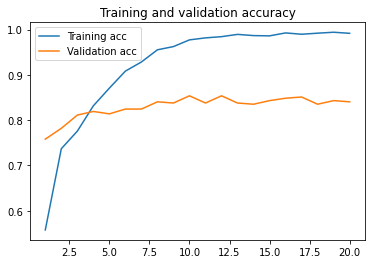

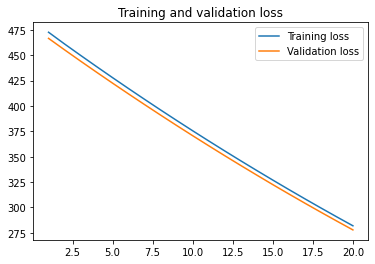

In [18]:
import matplotlib.pyplot as plt

acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()